In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

from importlib import reload
import visualise_speed as vs
reload(vs)

from celluloid import Camera
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
import os
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from IPython.display import Video

In [2]:
def plot_run_path(data_folder):
    files = sorted(os.listdir(data_folder))
    runs = files[-5:]

    for i, r in enumerate(runs):
        plt.figure(1, (10, 10))
        data = vs.load_data(f"{data_folder}/{r}")
        
        data = data[data.Step > 20]
        for e in range(data.Episode.max()):
            ep = data[data.Episode == e]
            if len(ep) > 0:
                plt.plot(ep.PosX, ep.PosZ, color="k", alpha=0.2)
                if len(ep) < 1000:
                    plt.plot(ep.PosX.values[-1], ep.PosZ.values[-1], marker="x", color = "k")

    plt.show()

# The traditional track (Figure 8)

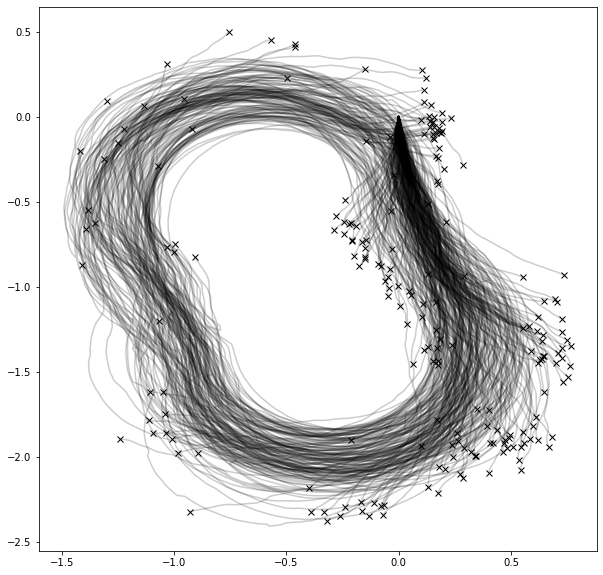

In [3]:
plot_run_path("./results/real_sac/figure_8/")

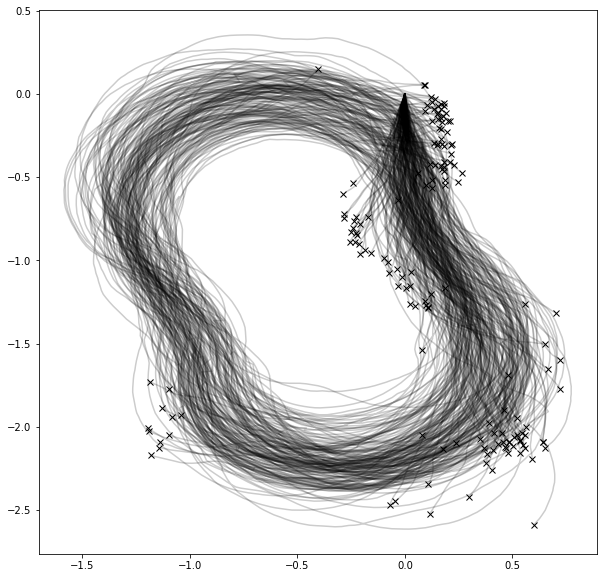

In [4]:
plot_run_path("./results/real_sac/figure_8_aug/")

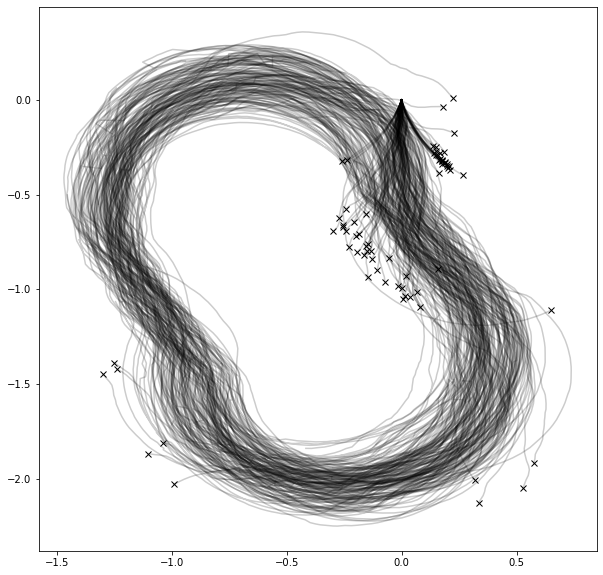

In [5]:
plot_run_path("./results/real_dreamer/figure_8/")

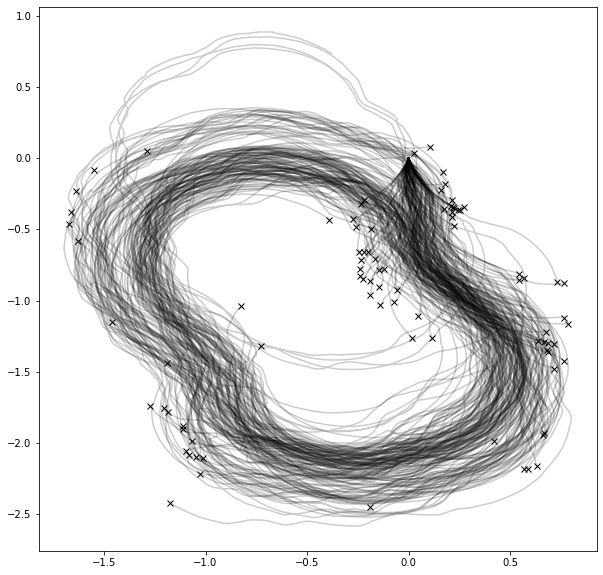

In [6]:
plot_run_path("./results/real_dreamer/figure_8_color/")

# Race track (haven't come up with a good name)

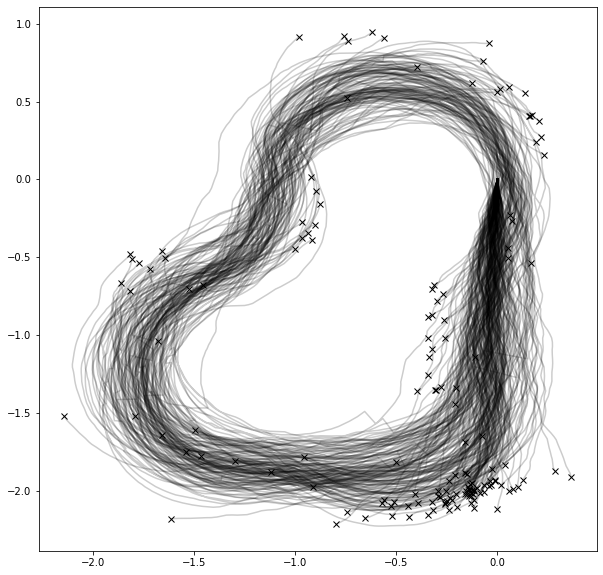

In [6]:
plot_run_path("./results/real_sac/track_aug/")

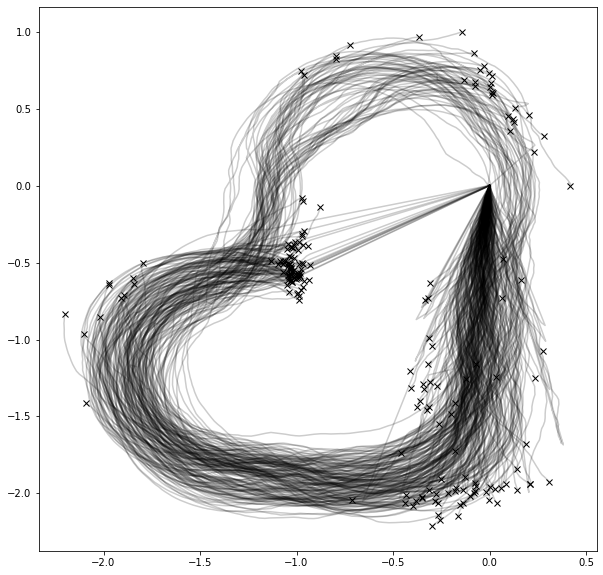

In [7]:
plot_run_path("./results/real_sac/track/")

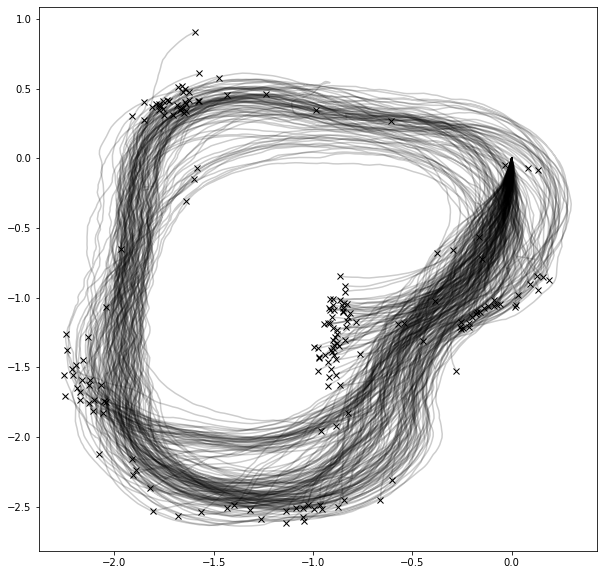

In [8]:
plot_run_path("./results/real_sac/track_favorable_start/")

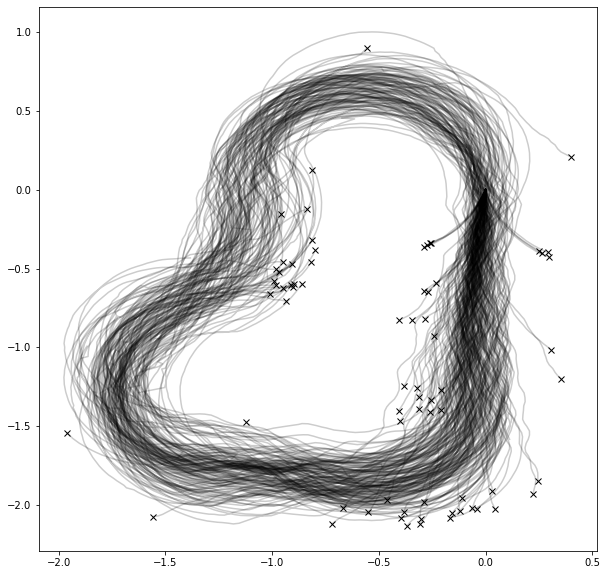

In [9]:
plot_run_path("./results/real_dreamer/track/")

# Square

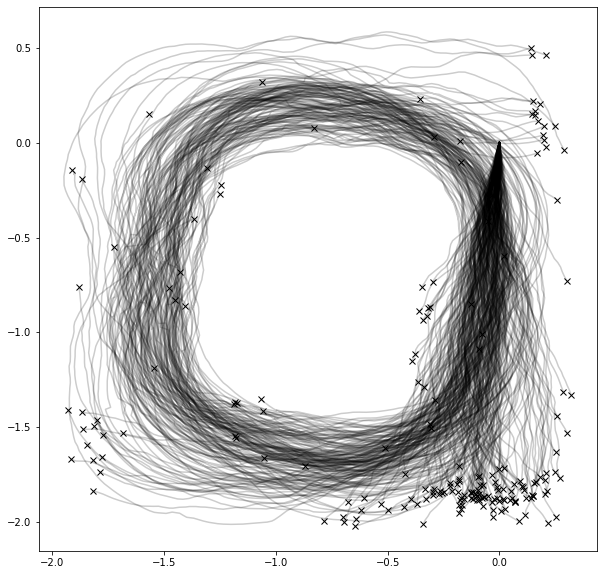

In [10]:
plot_run_path("./results/real_sac/square/")

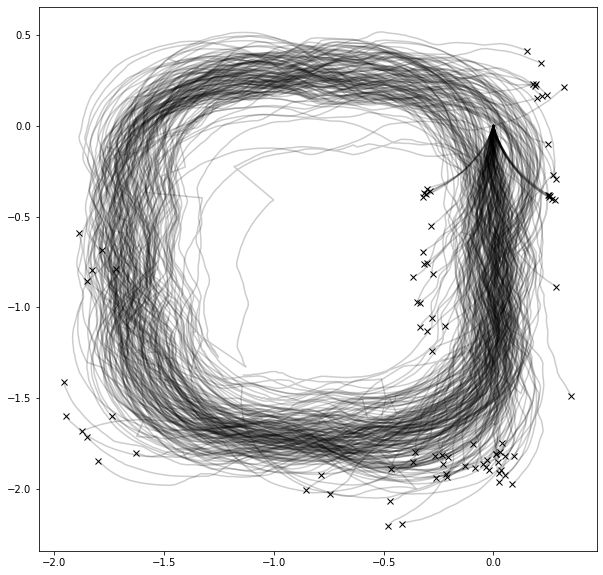

In [11]:
plot_run_path("./results/real_dreamer/square/")

In [49]:
def plot_run(data_folder, label, env_type="real"):

    runs = sorted([x for x in os.listdir(data_folder) if ".ipy" not in x])

    total = []

    for i, r in enumerate(runs):
        data = vs.load_data(f"{data_folder}/{r}")
        data = data[data.Step > 20]
        data = data[["Episode", "Step"]]
        episode_lengths = data.groupby("Episode").max().Step
        episode_lengths = data.groupby("Episode").max().Step
        episode_lengths = episode_lengths[episode_lengths > 1]

        cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])

        interp = interp1d(cum_env_steps, episode_lengths, fill_value="extrapolate")
        interp_x = np.arange(10000 if env_type=="real" else 20000)

        rewards = interp(interp_x)
        #print(rewards)
        total += zip(interp_x, rewards)
        #plt.scatter(cum_env_steps, episode_lengths, marker="x", alpha=1, label=f"Run {i + 1}")
        #plt.plot(cum_env_steps, episode_lengths.rolling(3).mean())

    total.sort(key=lambda x: x[0])

    all_cum_steps = [x[0] for x in total]
    all_episode_lengths = [x[1] for x in total]

    step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

    steps = step_rewards.groupby("steps").mean().reset_index()
    std = step_rewards.groupby("steps").std().reset_index()
    plt.plot(steps["steps"], steps["reward"], linewidth=2, label=label)
    plt.fill_between(steps["steps"], steps["reward"] - std["reward"], steps["reward"] + std["reward"], alpha=0.1)
    plt.ylim(0,1100)
    #plt.axhline(300, linestyle="--", color="r", label="One lap")
    plt.xlabel("Cumulative environment steps")
    plt.ylabel("Episode reward")
    plt.legend()

# Square

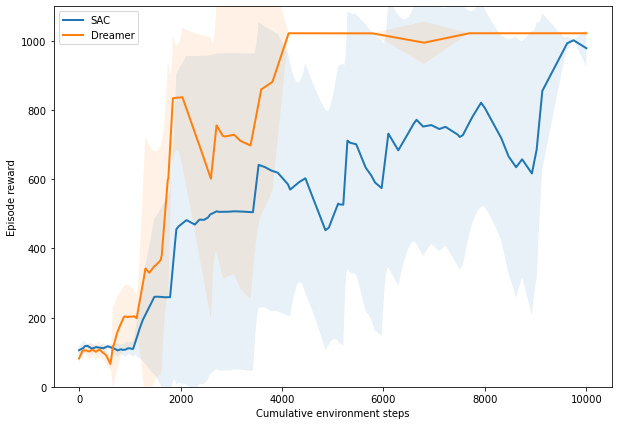

In [50]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/square/", "SAC")
plot_run("./results/real_dreamer/square/", "Dreamer")


# Figure 8
This is with the old setup with dreamer with 64x64 RGB and SAC has mirror augmentation so for full comparison this should probably be done again.

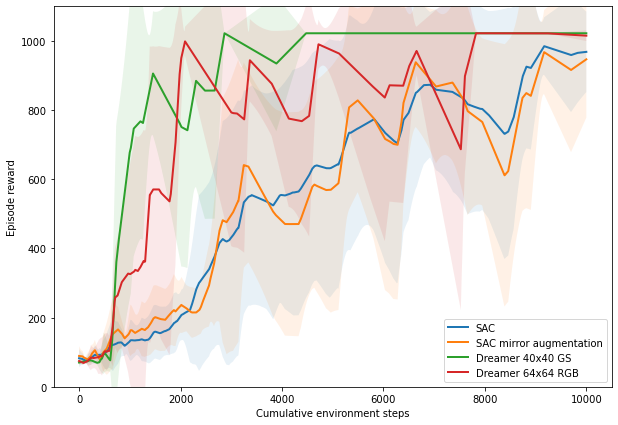

In [51]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/figure_8/", "SAC")
plot_run("./results/real_sac/figure_8_aug/", "SAC mirror augmentation")
plot_run("./results/real_dreamer/figure_8/", "Dreamer 40x40 GS")
plot_run("./results/real_dreamer/figure_8_color/", "Dreamer 64x64 RGB")


# Race track

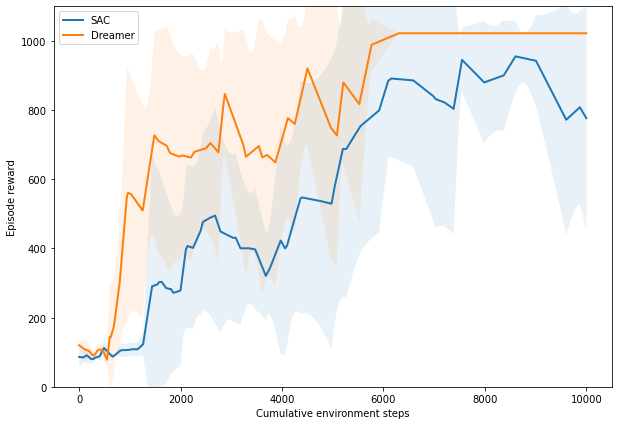

In [52]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/track_favorable_start/", "SAC")
plot_run("./results/real_dreamer/track/", "Dreamer")
plt.show()

In [53]:
sac_runs = [
    "./results/real_sac/track_favorable_start",
    "./results/real_sac/figure_8/",
    "./results/real_sac/square/"
]

dreamer_runs = [
    "./results/real_dreamer/track/",
    "./results/real_dreamer/square/",
    "./results/real_dreamer/figure_8/"
]

def plot_multiple(data_folders, label):
    runs = []

    for data_folder in data_folders:
        runs += [data_folder + "/" + x for x in os.listdir(data_folder) if ".ipy" not in x]

    total = []

    for i, r in enumerate(runs):
        data = vs.load_data(f"{r}")
        data = data[data.Step > 20]
        data = data[["Episode", "Step"]]
        episode_lengths = data.groupby("Episode").max().Step
        episode_lengths = episode_lengths[episode_lengths > 1]
        cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])

        interp = interp1d(cum_env_steps, episode_lengths, fill_value="extrapolate")
        interp_x = np.arange(10000)

        rewards = interp(interp_x)
        #print(rewards)
        total += zip(interp_x, rewards)
        #plt.scatter(cum_env_steps, episode_lengths, marker="x", alpha=1, label=f"Run {i + 1}")
        #plt.plot(cum_env_steps, episode_lengths.rolling(3).mean())

    total.sort(key=lambda x: x[0])

    all_cum_steps = [x[0] for x in total]
    all_episode_lengths = [x[1] for x in total]

    step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

    steps = step_rewards.groupby("steps").mean().reset_index()
    std = step_rewards.groupby("steps").std().reset_index()
    plt.plot(steps["steps"], steps["reward"], linewidth=2, label=label)
    plt.fill_between(steps["steps"], steps["reward"] - std["reward"], steps["reward"] + std["reward"], alpha=0.1)
    plt.ylim(0,1100)
    #plt.axhline(300, linestyle="--", color="r", label="One lap")
    plt.xlabel("Cumulative environment steps")
    plt.ylabel("Episode reward")
    plt.legend()

# All real car runs on top of each other 

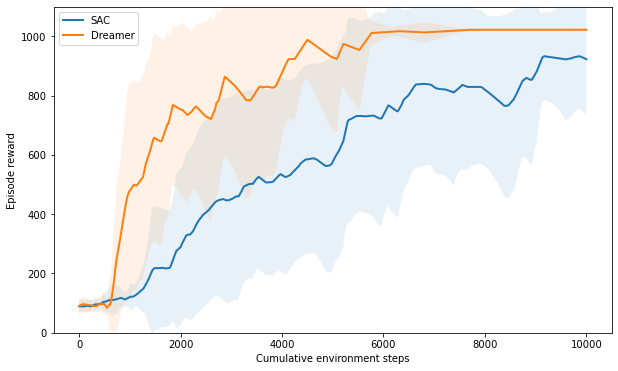

In [54]:
plt.figure(1, (10, 6))
plot_multiple(sac_runs, "SAC")
plot_multiple(dreamer_runs, "Dreamer")

This is a kind of an ablation study also. When I did runs for the race track, the car did not learn to drive well. I started the car at the beginning of the long straight and by the time the car got to the only right turn it had such a srong bias to turning left that it couldn't make the right turn. Only 2/5 runs learned to get past that turn.

I then tried from another spot where the car saw both turns early and it learned to drive much better. Then I also tried to do the image augmentation where I also introduce mirror images and controls to the replay buffer and this pretty much eliminates the sesitivity to the initial position and learns to drive even from the unfavorable start.

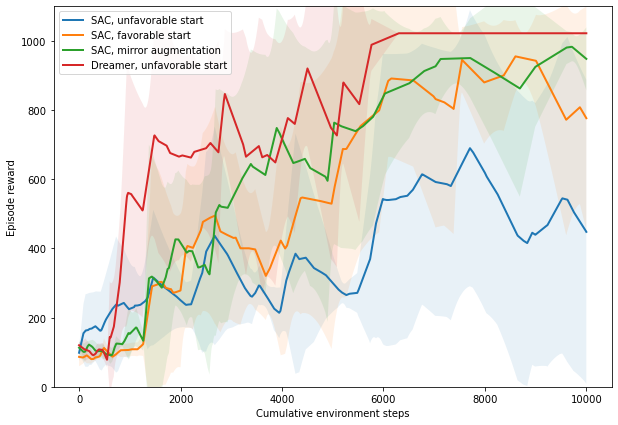

In [55]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/track", "SAC, unfavorable start")
plot_run("./results/real_sac/track_favorable_start", "SAC, favorable start")
plot_run("./results/real_sac/track_aug", "SAC, mirror augmentation")
plot_run("./results/real_dreamer/track/", "Dreamer, unfavorable start")
plt.show()

# Simulator

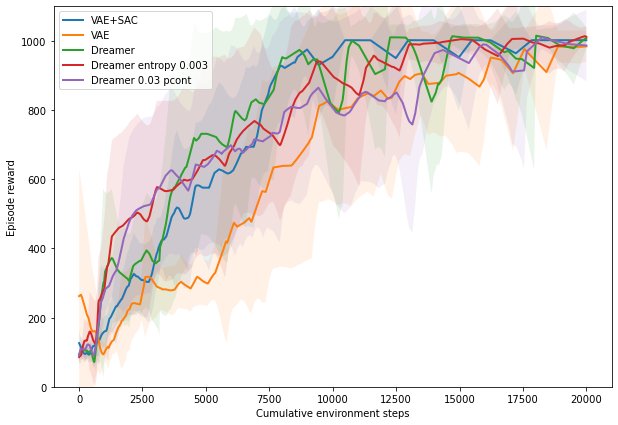

In [56]:
plt.figure(1, (10, 7))
plot_run("./results/sim_aesac/", label="VAE+SAC", env_type="sim")
plot_run("./results/sim_vae", label="VAE", env_type="sim")
plot_run("./results/sim_dreamer/", label="Dreamer", env_type="sim")
plot_run("./results/gray_entropy_0.003/", label="Dreamer entropy 0.003", env_type="sim")
plot_run("./results/0.03_pcont/", label="Dreamer 0.03 pcont", env_type="sim")

plt.show()

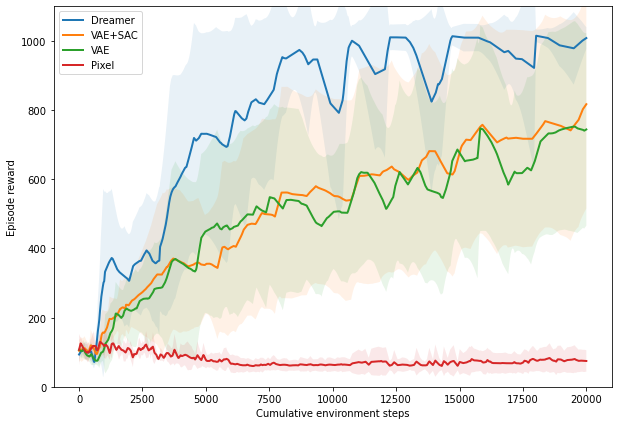

In [57]:
plt.figure(1, (10, 7))
#plot_run("./results/sim_aesac/", label="VAE+SAC", env_type="sim")
#plot_run("./results/sim_vae", label="VAE", env_type="sim")
plot_run("./results/sim_dreamer/", label="Dreamer", env_type="sim")
plot_run("./results/sim_sac/aesac/", "VAE+SAC", env_type="sim")
plot_run("./results/sim_sac/ae/", "VAE", env_type="sim")
plot_run("./results/sim_sac/pixel/", "Pixel", env_type="sim")
plt.show()

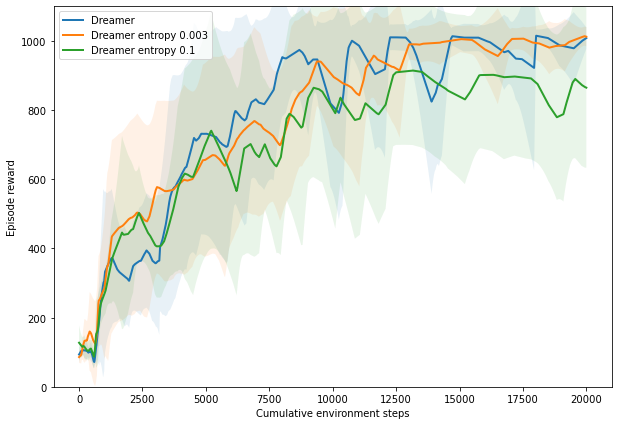

In [58]:
plt.figure(1, (10, 7))
#plot_run("./results/sim_aesac/", label="VAE+SAC", env_type="sim")
#plot_run("./results/sim_vae", label="VAE", env_type="sim")
plot_run("./results/sim_dreamer/", label="Dreamer", env_type="sim")
plot_run("./results/gray_entropy_0.003/", label="Dreamer entropy 0.003", env_type="sim")
#plot_run("./results/0.03_pcont/", label="Dreamer 0.03 pcont", env_type="sim")
plot_run("./results/0.1/", label="Dreamer entropy 0.1", env_type="sim")

plt.show()

# Generalization 

In [23]:
sac_files = sorted(os.listdir("./results/generalization/sac"))
dreamer_files = sorted(os.listdir("./results/generalization/dreamer/"))

In [36]:
print("SAC:\n")
for f in sac_files:
    run = vs.load_data(f"./results/generalization/sac/{f}")
    run = run[run.Episode > 1]
    lens = run.groupby("Episode").max().Step.values
    lens = lens[lens > 1]
    print(f"Test: {f:35} Performance: {lens.mean() / 10.02:6.2f}%")

print("\n\nDreamer:\n")
for f in dreamer_files:
    run = vs.load_data(f"./results/generalization/dreamer/{f}")
    run = run[run.Episode > 1]
    lens = run.groupby("Episode").max().Step.values
    lens = lens[lens > 1]
    print(f"Test: {f:35} Performance: {lens.mean() / 10.22:6.2f}%")

SAC:

Test: train_figure_8_eval_figure_8.csv    Performance: 100.00%
Test: train_figure_8_eval_square.csv      Performance: 100.00%
Test: train_figure_8_eval_track.csv       Performance: 100.00%
Test: train_square_eval_figure_8.csv      Performance:  21.70%
Test: train_square_eval_square.csv        Performance: 100.00%
Test: train_square_eval_track.csv.csv     Performance:  22.32%
Test: train_track_eval_figure_8.csv       Performance: 100.00%
Test: train_track_eval_square.csv         Performance:  94.78%
Test: train_track_eval_track.csv          Performance:  50.58%


Dreamer:

Test: train_figure_8_eval_figure_8.csv    Performance: 100.00%
Test: train_figure_8_eval_square.csv      Performance: 100.00%
Test: train_figure_8_eval_track.csv       Performance: 100.00%
Test: train_square_eval_figure_8.csv      Performance:  98.92%
Test: train_square_eval_square.csv        Performance: 100.00%
Test: train_square_eval_track.csv         Performance:  24.98%
Test: train_track_eval_figure_8.csv  

In [35]:
for f in dreamer_files:
    run = vs.load_data(f"./results/generalization/dreamer/{f}")
    run = run[run.Episode > 1]
    lens = run.groupby("Episode").max().Step.values
    lens = lens[lens > 1]
    print(f"Test: {f:35}, Performance: {lens.mean() / 10.22:6.2f}%")

Test: train_figure_8_eval_figure_8.csv   , Performance: 100.00%
Test: train_figure_8_eval_square.csv     , Performance: 100.00%
Test: train_figure_8_eval_track.csv      , Performance: 100.00%
Test: train_square_eval_figure_8.csv     , Performance:  98.92%
Test: train_square_eval_square.csv       , Performance: 100.00%
Test: train_square_eval_track.csv        , Performance:  24.98%
Test: train_track_eval_figure_8.csv      , Performance: 100.00%
Test: train_track_eval_square.csv        , Performance:  47.79%
Test: train_track_eval_track.csv         , Performance:  89.65%
